## Tensor Network Transfer Learning

Imports

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# Path to folder containing .npz files
folder_path = 'data/transfer_learning_tdvp'

# List all .npz files
npz_files = [f for f in os.listdir(folder_path) if f.endswith('.npz')]

# Load each file
zs=[]
hs=[]
for file_name in npz_files:
    file_path = os.path.join(folder_path, file_name)
    data = np.load(file_path)
    
    #print(f"Loaded {file_name}")
    #print(f"Keys: {list(data.keys())}")
    hs.append(data['drivings'])
    zs.append(data['z_values'])
    time=data['time']
    # Example: access array by key
    # array = data['some_array_key']
hs=np.asarray(hs).reshape(-1,time.shape[0])
zs=np.asarray(zs).reshape(-1,time.shape[0])

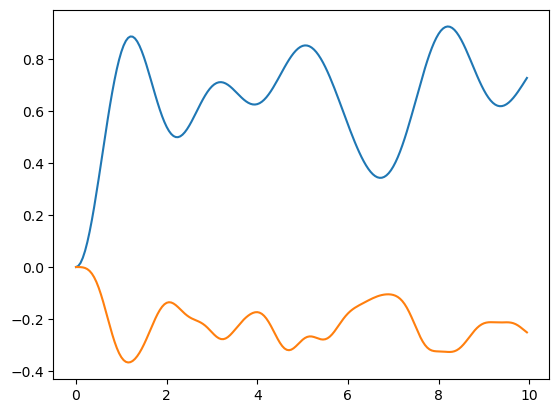

In [43]:
idx=np.random.randint(0,hs.shape[0])
plt.plot(time,hs[idx])
plt.plot(time,zs[idx])
plt.show()

#### Compute the $h_{eff}$

In [125]:
from src.tddft_methods.tddft_solver import Driving,second_derivative_formula
from tqdm import trange
from scipy.sparse.linalg import eigsh,expm

derivative_formula='9-points'
pbc=True

# New extended time grid
steps_tddft=1000
l=1
time_tddft = np.linspace(0, 10, steps_tddft)  # longer than original

# Allocate array for new drivings
drivings_new = np.zeros((hs.shape[0], len(time_tddft)))
magnetization_new=np.zeros((hs.shape[0], len(time_tddft)))
# Interpolate each batch element
for i in range(hs.shape[0]):
    f = interp1d(time, hs[i], kind='cubic', fill_value='extrapolate')
    g= interp1d(time, zs[i], kind='cubic', fill_value='extrapolate')
    drivings_new[i] = f(time_tddft)
    magnetization_new[i]=g(time_tddft)


In [126]:
z_reconstruction=np.zeros((hs.shape[0],steps_tddft,l))
h_eff_vector=np.zeros((hs.shape[0],steps_tddft,l))
for q in range(100):
    # compute the effective field
    psi=np.zeros((2,l))
    z_exp=magnetization_new[q][:,None]*np.ones(l)[None,:]
    psi[0] = np.sqrt((1 + z_exp[0]) / 2)
    psi[1] = np.sqrt((1 - z_exp[0]) / 2)

    omega=1.
    j=-1
    # build up the operators
    x_op=np.array([[0.,1.],[1.,0]])
    z_op=np.array([[1.,0.],[0.,-1.]])


    # extrapolate the fields
    #f=interp1d(time,z_exp,axis=0)
    #z_tddft=f(time_tddft)
    z_tddft=z_exp
    current_derivative_tddft=second_derivative_formula(z_tddft,dt=time_tddft[1]-time_tddft[0],derivative_formula=derivative_formula)



    dt=time_tddft[1]-time_tddft[0]    


    for i in trange(steps_tddft):
        psi_r=psi.copy()
        for f in range(1):
            x_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),x_op,psi_r)
            z_ave=np.einsum('al,ab,bl->l',np.conj(psi_r),z_op,psi_r)
            
            if pbc:
                #pbc
                nonlinear_term=np.abs(j)*(np.roll(x_ave,shift=1)+np.roll(x_ave,shift=-1))+omega
            
            else:
                #obc
                shift_plus=np.zeros(l)
                shift_plus[1:]=x_ave[1:] #np.roll(x_sp,shift=1,axis=-1)
                shift_minus=np.zeros(l)
                shift_minus[:-1]=x_ave[:-1] #np.roll(x_sp,shift=-1,axis=-1)
                #print(shift_minus,shift_plus)
                nonlinear_term=np.abs(j)*(shift_plus+shift_minus)+omega+10**-10
            h_eff=(0.25*current_derivative_tddft[i]/nonlinear_term+z_tddft[i]*nonlinear_term)/(x_ave+10**-10)
            h_eff_vector[q,i]=h_eff
            hamiltonian_t=nonlinear_term[:,None,None]*x_op[None,:,:]+h_eff[:,None,None]*z_op[None,:,:]
            exp_h_t=np.zeros((l,2,2),dtype=np.complex128)
            
            for r in range(l):
                exp_h_t[r]=expm(-1j*dt*hamiltonian_t[r])
            #print(exp_h_t)    
            psi_r=np.einsum('lab,bl->al',exp_h_t,psi)
            psi_r=psi_r/np.linalg.norm(psi_r,axis=0)
            
            
        psi=np.einsum('lab,bl->al',exp_h_t,psi)
        psi=psi/np.linalg.norm(psi,axis=0)
        
        z_reconstruction[q,i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_828624/3454082734.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  z_reconstruction[q,i]=np.einsum('al,ab,bl->l',np.conj(psi),z_op,psi)
/tmp/ipykernel_828624/3454082734.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  h_eff_vector[q,i]=h_eff
100%|██████████| 1000/1000 [00:00<00:00, 2066.51it/s]


In [ ]:
idx=np.random.randint(0,100)
print(idx,z_reconstruction.shape)
plt.plot(time_tddft,z_reconstruction[idx,:,0])
plt.plot(time_tddft,magnetization_new[idx,:])
plt.show()

plt.plot(time_tddft,h_eff_vector[idx,:,0])
plt.show()

In [148]:
print(drivings_new.shape,zs.shape)
input=np.zeros((drivings_new.shape[0],drivings_new.shape[1]+1,1))
output=np.zeros((h_eff_vector.shape[0],h_eff_vector.shape[1]+1,h_eff_vector.shape[2]))
input[:,1:,0]=drivings_new
input[:,0,0]=zs[:,0]

output[:,1:]=h_eff_vector

np.savez('data/transfer_learning_dataset',h_eff=output,h=input)

(100, 1000) (100, 200)
